In [1]:
import numpy as np
import time
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import TimeDistributed, Dense, Flatten,ConvLSTM2D,RepeatVector
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import tensorflow as tf 
from keras import backend as k 


from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Conv2D, Flatten, Dense, TimeDistributed, ConvLSTM2D, RepeatVector

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
#df1=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno1/eplusout/eplusout.csv')
#df2=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno2/eplusout/eplusout.csv')
#df3=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno3/eplusout/eplusout.csv')
df1=pd.read_csv('../data/eplusout_1.csv')
df2=pd.read_csv('../data/eplusout_2.csv')
df3=pd.read_csv('../data/eplusout_3.csv')

In [3]:
#Set number of timestep to use for prediction and to predict
n_in = 12
n_out = 6
verbose=False

In [4]:
def changetime(df,year):
    datetimeform = []
    for i in range(len(df.index)):
        tt = df["Date/Time"][i]
        days, hours = tt.split('  ')
        tt = f'{days.split("/")[1]}/{days.split("/")[0]}/{year}{hours}'
        tt = tt.replace(' ', '')
        if '201724:' or '201824:' or '201924:' in tt:
            tt=tt.replace('24:', '00:')
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            timestamp += 86400
            #timestamp = datetime.fromtimestamp(timestamp)

        else:
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            #timestamp = datetime.fromtimestamp(timestamp)
        datetimeform.append(timestamp)

    df["TimeStep"]=datetimeform
    
changetime(df1,"2017")
changetime(df2,"2018")
changetime(df3,"2019")
df1.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](TimeStep),...,DistrictCooling:Facility [J](TimeStep),DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),TimeStep
0,04/01 00:10:00,15.433333,NaN,10.3,NaN,101250.666667,NaN,3.0,NaN,19.166667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
1,04/01 00:20:00,14.366667,NaN,10.0,NaN,101280.333333,NaN,2.9,NaN,8.333333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
2,04/01 00:30:00,13.300000,NaN,9.7,NaN,101310.000000,NaN,2.8,NaN,357.500000,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
3,04/01 00:40:00,12.233333,NaN,9.4,NaN,101339.666667,NaN,2.7,NaN,346.666667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
4,04/01 00:50:00,11.166667,NaN,9.1,NaN,101369.333333,NaN,2.6,NaN,335.833333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491087e+09


In [5]:
def add_setpoint_attribute(df,setpoint=26):
    df["Delta Setpoint"] = setpoint-df["Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)"]
    
add_setpoint_attribute(df1)
add_setpoint_attribute(df2)
add_setpoint_attribute(df3)
df2.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](TimeStep),...,DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),TimeStep,Delta Setpoint
0,04/01 00:10:00,11.916667,NaN,4.866667,NaN,100550.0,NaN,1.466667,NaN,5.0,...,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.522621e+09,14.083333
1,04/01 00:20:00,11.833333,NaN,5.733333,NaN,100700.0,NaN,1.433333,NaN,0.0,...,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.522621e+09,14.166667
2,04/01 00:30:00,11.750000,NaN,6.600000,NaN,100850.0,NaN,1.400000,NaN,355.0,...,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.522622e+09,14.250000
3,04/01 00:40:00,11.666667,NaN,7.466667,NaN,101000.0,NaN,1.366667,NaN,350.0,...,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.522622e+09,14.333333
4,04/01 00:50:00,11.583333,NaN,8.333333,NaN,101150.0,NaN,1.333333,NaN,345.0,...,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.522623e+09,14.416667


#Extract mean temp time series
#mean value of the 3 indoor zones
def meanDF(df):
    df_mean = pd.DataFrame()
    #"Date/Time",\
    #"Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",\
    #"Electricity:Facility [J](TimeStep)"
    df_mean = df[[
              "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
              "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
              "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)",\
              ]]
    df_temp=df_mean.copy()
    df_temp.dropna(inplace=True)
    df_temp["mean"] = df_temp.mean(1)


    df_final=pd.DataFrame()
    df_final["DateTime"] = df["TimeStep"]
    df_final["Outdoor_Mean"] = df["Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)"]
    df_final["Indoor_Mean"] = df_temp["mean"]
    df_final["Cooling"] = df["DistrictCooling:Facility [J](TimeStep)"]
    df_final["Power"]=df["Electricity:Facility [J](TimeStep)"]
    df_final["Delta_T"] = df_final["Indoor_Mean"]-df_final["Outdoor_Mean"]
    
    #df_final
    return df_final

df1_final=meanDF(df1)
df2_final=meanDF(df2)
df3_final=meanDF(df3)
df1_final.head()

In [6]:
# selecting only the values to train the rnn on 
x = pd.DataFrame()
meas = [
        #"TimeStep",
        "DistrictCooling:Facility [J](TimeStep)",
        "Electricity:Facility [J](TimeStep)",
        "Delta Setpoint",
        "Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",
        "Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)",
        "Environment:Site Wind Speed [m/s](TimeStep)",
        "Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)",
        "Environment:Site Wind Direction [deg](TimeStep)",
        "Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)",
        "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",
        "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",
        "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)"]

#x["Indoor_Mean"] = pd.concat([df1_final["Indoor_Mean"],df2_final["Indoor_Mean"],df3_final["Indoor_Mean"]])

for m in meas:
    x[m]=pd.concat([df1[m],df2[m],df3[m]])
#x.set_index("TimeStep",inplace=True)
#x.head()
x.reset_index(inplace=True,drop=True)

In [7]:
column_indices = {name: i for i, name in enumerate(x.columns)}
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DistrictCooling:Facility [J](TimeStep),79056.0,441039.629665,415165.286807,0.000000,0.000000,371067.417449,810164.510486,1.589935e+06
Electricity:Facility [J](TimeStep),79056.0,137106.182864,171247.171743,27449.355191,27449.355191,27449.355191,339447.592364,6.390397e+05
Delta Setpoint,79056.0,1.640344,5.218590,-12.000000,-2.300000,1.200000,4.904167,1.980000e+01
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),79056.0,24.359656,5.218590,6.200000,21.095833,24.800000,28.300000,3.800000e+01
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,283.717416,335.925819,0.000000,0.000000,47.000000,655.333333,9.190000e+02
Environment:Site Wind Speed [m/s](TimeStep),79056.0,3.948260,2.656548,0.000000,1.900000,3.350000,5.600000,1.650000e+01
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),79056.0,101022.317768,348.420867,99682.000000,100792.833333,101100.000000,101297.000000,1.022000e+05
Environment:Site Wind Direction [deg](TimeStep),79056.0,209.793672,88.844315,0.000000,171.666667,216.666667,280.000000,3.598333e+02
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,80.631622,90.721616,0.000000,0.000000,51.000000,145.500000,5.320000e+02
BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON),79056.0,25.308202,1.075741,20.347476,24.286661,26.000000,26.000000,2.600000e+01


In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
reframed = series_to_supervised(x.to_numpy(), n_in, n_out)
if verbose:
    reframed.head()
#reframed.shape

#range(x.shape[1]*n_in+1,x.shape[1]*n_in+x.shape[1])

In [10]:
columns=[]
for i in range(n_out):
    for c in reframed.columns[range(x.shape[1]*n_in+1+i*x.shape[1],x.shape[1]*n_in+ (i+1)*x.shape[1])]:
        columns.append(c)
if verbose:
    print(columns)
reframed.drop(columns, axis=1, inplace=True)
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),...,var9(t-1),var10(t-1),var11(t-1),var12(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
12,0.0,27449.355191,10.566667,15.433333,0.0,3.0,101250.666667,19.166667,0.0,22.985965,...,0.0,22.246359,22.696604,22.730157,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,27449.355191,11.633333,14.366667,0.0,2.9,101280.333333,8.333333,0.0,22.877529,...,0.0,22.218611,22.663102,22.692081,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,27449.355191,12.700000,13.300000,0.0,2.8,101310.000000,357.500000,0.0,22.760018,...,0.0,22.186099,22.628571,22.653075,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,27449.355191,13.766667,12.233333,0.0,2.7,101339.666667,346.666667,0.0,22.648376,...,0.0,22.156092,22.593908,22.613797,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,27449.355191,14.833333,11.166667,0.0,2.6,101369.333333,335.833333,0.0,22.541140,...,0.0,22.124171,22.559529,22.574715,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#n_in = 6
#n_out = 2
#reframed = series_to_supervised(x.to_numpy(), n_in, n_out)
#reframed.drop(reframed.columns[range(x.shape[1]*n_in+1,x.shape[1]*n_in+x.shape[1])], axis=1, inplace=True)
#reframed.head()
#reframed.shape

In [12]:
# Split dataset into train, validation and test and normalize data

ntot = reframed.shape[0]
values = reframed.values

#first two years for training 
x_train = values[:(len(df1)+len(df2)), :]
#x_train.set_index("TimeStep",inplace=True)
mean = x_train.mean()
std = x_train.std()
x_train_norm = (x_train - mean)/std
print("Training set dimension: ",len(x_train))

x_val =  values[(len(df1)+len(df2)): (len(df1)+len(df2)) + int(0.5*len(df3)), :]
#x_val.set_index("TimeStep",inplace=True)
x_val_norm = (x_val-mean)/std
print("Validation set dimension: ",len(x_val))

x_test =  values[(len(df1)+len(df2)) + int(0.5*len(df3)):, :]
#x_test.set_index("TimeStep",inplace=True)
x_test_norm = (x_test-mean)/std
print("Test set dimension: ",len(x_test))

train_X, train_y = x_train_norm[:, :-n_out],  x_train_norm[:, -n_out:]
val_X, val_y = x_val_norm[:, :-n_out],  x_val_norm[:, -n_out:]
test_X, test_y = x_test_norm[:, :-n_out],  x_test_norm[:, -n_out:]

Training set dimension:  52704
Validation set dimension:  13176
Test set dimension:  13159


In [13]:
def bi_lstm_model():
	model = Sequential()
	model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2,activation='relu')))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Flatten()))
	model.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True)))
	model.add(Bidirectional(LSTM(64, activation='relu')))
	model.add(Dense(128))
	model.add(Dropout(0.5))
	model.add(Dense(n_out))
	model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
	return model

In [14]:
#CNN-Bi-LSTM 
#n_steps, n_features = train_X.shape[1], train_X.shape[2]
n_features = 1 #da predirre
n_seq = 1
n_steps = 12*(n_in)

train_X = train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features))
val_X = val_X.reshape((val_X.shape[0], n_seq, n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seq, n_steps, n_features))

#Define Model
model = bi_lstm_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 143, 64)     192       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 71, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 70, 64)      8256      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 35, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2240)        0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         1180160   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               9

In [15]:
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_data=(val_X, val_y), verbose=1)

Epoch 1/100
1757/1757 [==============================] - 43s 25ms/step - loss: 0.5508 - mae: 0.4482 - mse: 0.5508 - mape: 91.1653 - val_loss: 0.1931 - val_mae: 0.2566 - val_mse: 0.1931 - val_mape: 70.5938
Epoch 2/100
1757/1757 [==============================] - 44s 25ms/step - loss: 0.3956 - mae: 0.3700 - mse: 0.3956 - mape: 85.7543 - val_loss: 0.1816 - val_mae: 0.2224 - val_mse: 0.1816 - val_mape: 90.4030
Epoch 3/100
1757/1757 [==============================] - 43s 25ms/step - loss: 0.3735 - mae: 0.3560 - mse: 0.3735 - mape: 88.0385 - val_loss: 0.1965 - val_mae: 0.2339 - val_mse: 0.1965 - val_mape: 78.1217
Epoch 4/100
1757/1757 [==============================] - 41s 23ms/step - loss: 0.3580 - mae: 0.3461 - mse: 0.3580 - mape: 93.2053 - val_loss: 0.1864 - val_mae: 0.2207 - val_mse: 0.1864 - val_mape: 86.8373
Epoch 5/100
1757/1757 [==============================] - 40s 23ms/step - loss: 0.3482 - mae: 0.3409 - mse: 0.3482 - mape: 94.7497 - val_loss: 0.1765 - val_mae: 0.2226 - val_mse: 0.

Epoch 41/100
1757/1757 [==============================] - 28s 16ms/step - loss: 0.2025 - mae: 0.2637 - mse: 0.2025 - mape: 95.1365 - val_loss: 0.1375 - val_mae: 0.1864 - val_mse: 0.1375 - val_mape: 78.7594
Epoch 42/100
1757/1757 [==============================] - 28s 16ms/step - loss: 0.2028 - mae: 0.2628 - mse: 0.2028 - mape: 95.3170 - val_loss: 0.1458 - val_mae: 0.1693 - val_mse: 0.1458 - val_mape: 75.8202
Epoch 43/100
1757/1757 [==============================] - 28s 16ms/step - loss: 0.2012 - mae: 0.2629 - mse: 0.2012 - mape: 92.4519 - val_loss: 0.1503 - val_mae: 0.1854 - val_mse: 0.1503 - val_mape: 72.7291
Epoch 44/100
1757/1757 [==============================] - 28s 16ms/step - loss: 0.1993 - mae: 0.2616 - mse: 0.1993 - mape: 95.4611 - val_loss: 0.1464 - val_mae: 0.2004 - val_mse: 0.1464 - val_mape: 93.8246
Epoch 45/100
1757/1757 [==============================] - 28s 16ms/step - loss: 0.2008 - mae: 0.2628 - mse: 0.2008 - mape: 91.6206 - val_loss: 0.1395 - val_mae: 0.1899 - val_ms

Epoch 81/100
1757/1757 [==============================] - 27s 16ms/step - loss: 0.1707 - mae: 0.2496 - mse: 0.1707 - mape: 83.4693 - val_loss: 0.1278 - val_mae: 0.1785 - val_mse: 0.1278 - val_mape: 76.1012
Epoch 82/100
1757/1757 [==============================] - 27s 16ms/step - loss: 0.1623 - mae: 0.2461 - mse: 0.1623 - mape: 84.4437 - val_loss: 0.1264 - val_mae: 0.1914 - val_mse: 0.1264 - val_mape: 77.5558
Epoch 83/100
1757/1757 [==============================] - 28s 16ms/step - loss: 0.1679 - mae: 0.2480 - mse: 0.1679 - mape: 86.7952 - val_loss: 0.1320 - val_mae: 0.1795 - val_mse: 0.1320 - val_mape: 70.9254
Epoch 84/100
1757/1757 [==============================] - 28s 16ms/step - loss: 0.1603 - mae: 0.2459 - mse: 0.1603 - mape: 85.1307 - val_loss: 0.1244 - val_mae: 0.1797 - val_mse: 0.1244 - val_mape: 78.5303
Epoch 85/100
1757/1757 [==============================] - 28s 16ms/step - loss: 0.1627 - mae: 0.2464 - mse: 0.1627 - mape: 83.4231 - val_loss: 0.1320 - val_mae: 0.2148 - val_ms

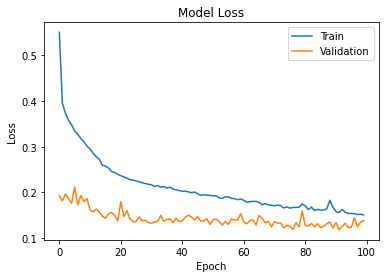

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [17]:
# make a prediction
yhat = model.predict(test_X)
print(test_X.shape)

(13159, 1, 144, 1)


In [18]:
pred_denorm = [t*std+mean for t in yhat]
pred_df = pd.DataFrame(pred_denorm)
pred_df.head()

,0,1,2,3,4,5
0,1.016945e+06,1.023179e+06,1.026576e+06,1.042376e+06,1052368.250,1052365.250
1,1.021147e+06,1.027352e+06,1.030534e+06,1.046199e+06,1056147.000,1056098.875
2,1.026417e+06,1.033297e+06,1.036440e+06,1.052094e+06,1062321.000,1062312.625
3,1.031245e+06,1.038937e+06,1.041966e+06,1.057464e+06,1067917.625,1067938.375
4,1.036310e+06,1.045044e+06,1.048087e+06,1.063541e+06,1074333.875,1074412.375


In [19]:
test_denorm = [t*std+mean for t in test_y]
test = pd.DataFrame(test_denorm)
test.head()

,0,1,2,3,4,5
0,1.038617e+06,1.044376e+06,1.049304e+06,1.054443e+06,1.058257e+06,1.062342e+06
1,1.044376e+06,1.049304e+06,1.054443e+06,1.058257e+06,1.062342e+06,1.065092e+06
2,1.049304e+06,1.054443e+06,1.058257e+06,1.062342e+06,1.065092e+06,1.068635e+06
3,1.054443e+06,1.058257e+06,1.062342e+06,1.065092e+06,1.068635e+06,1.074057e+06
4,1.058257e+06,1.062342e+06,1.065092e+06,1.068635e+06,1.074057e+06,1.076245e+06


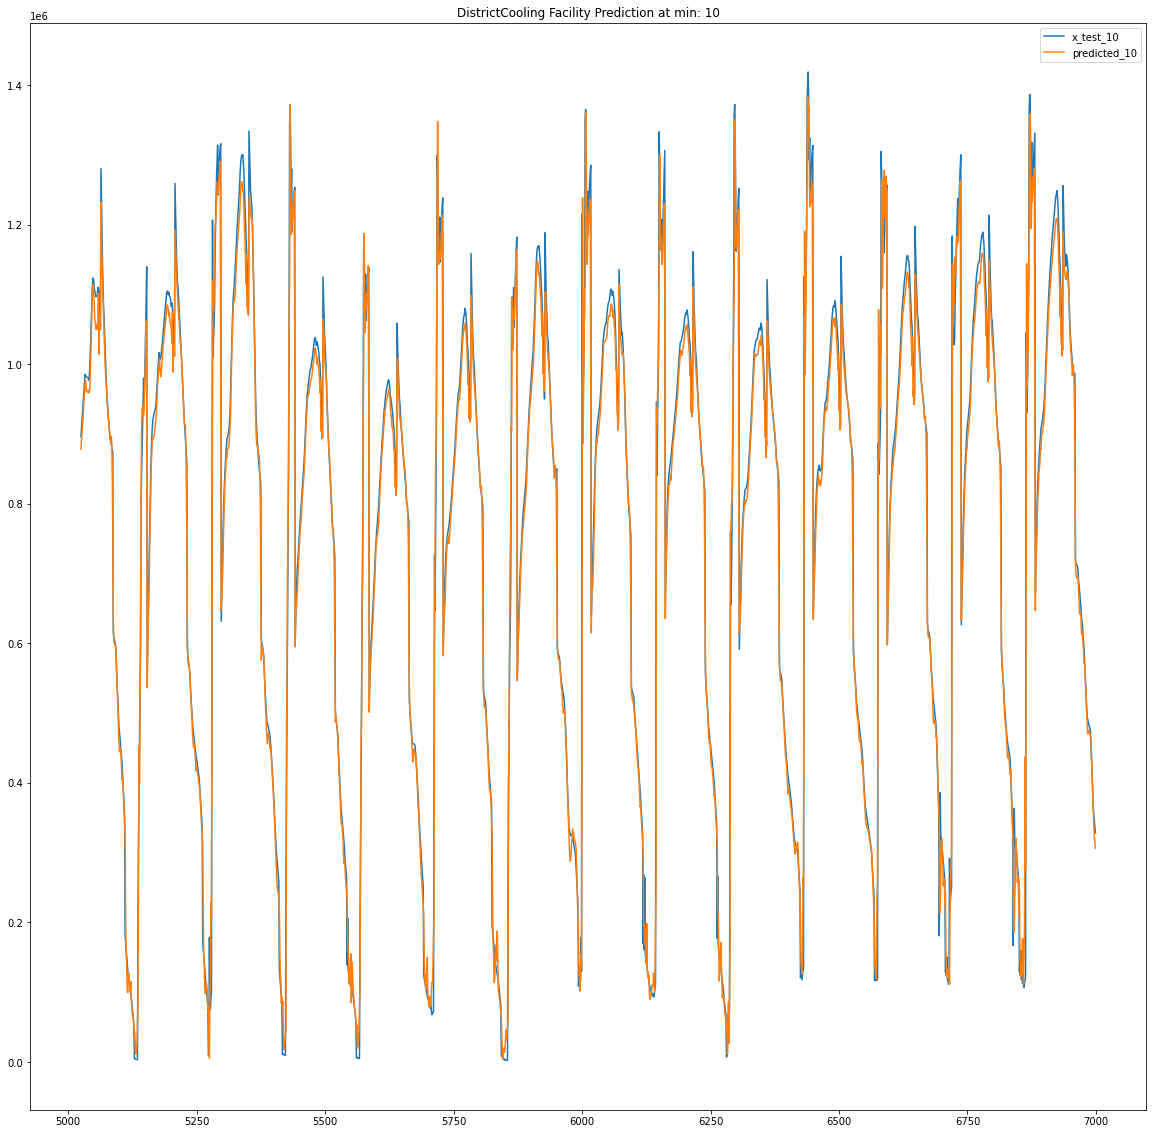

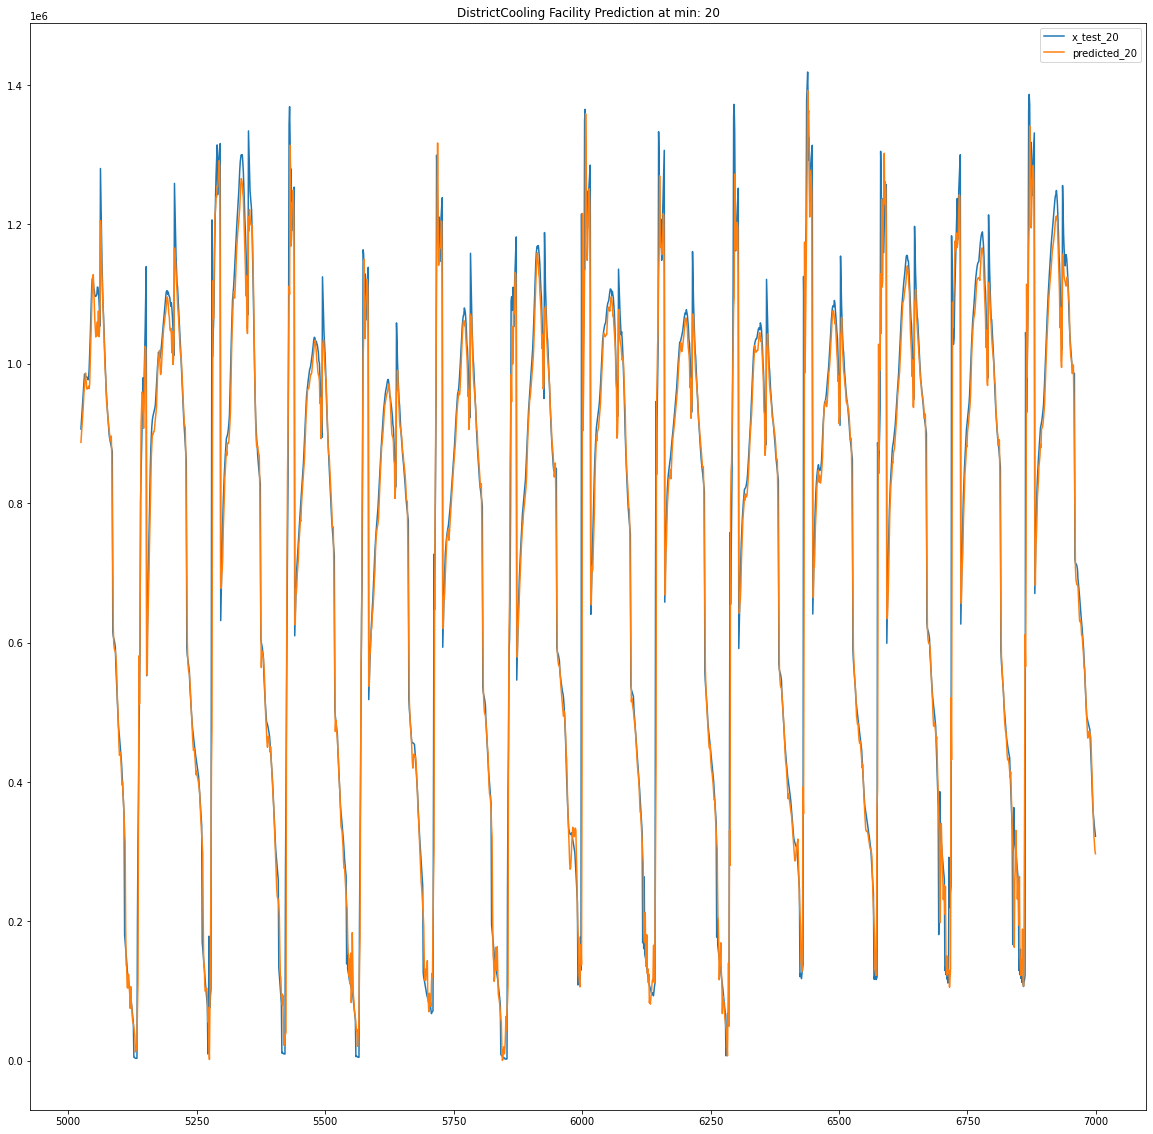

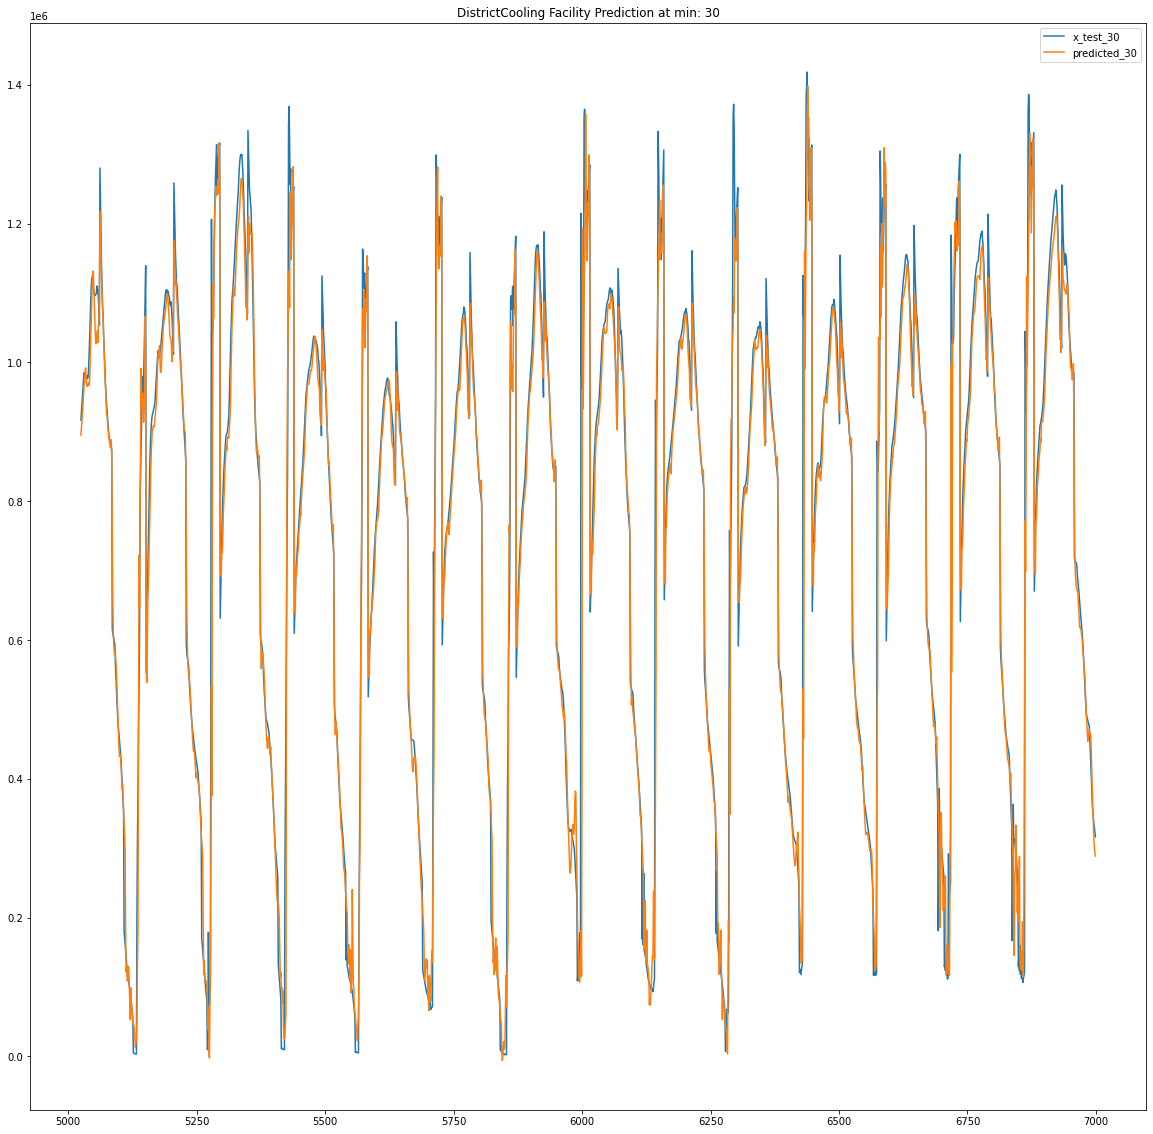

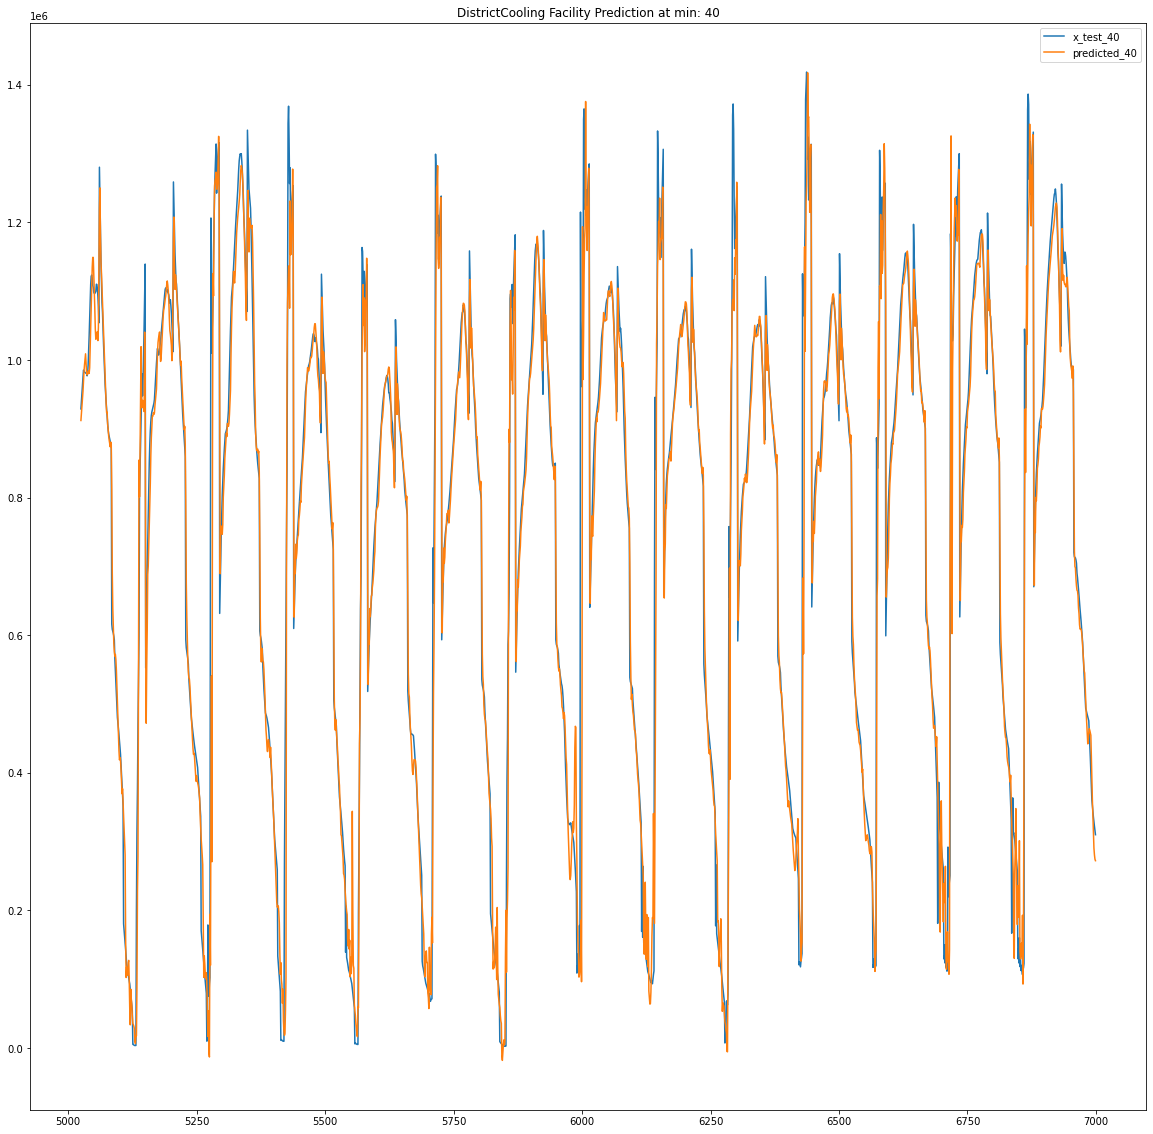

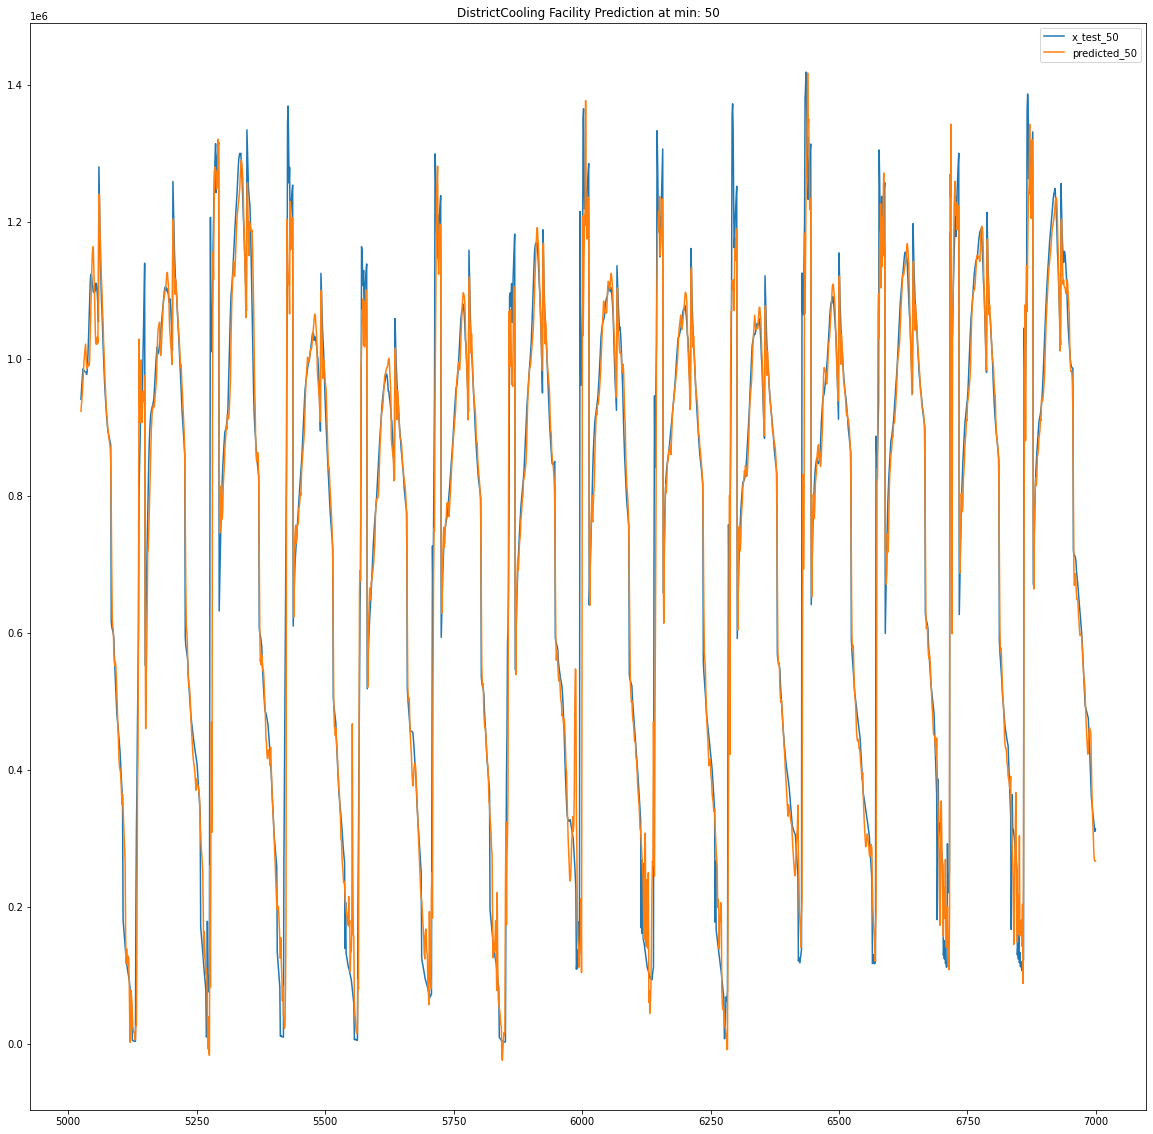

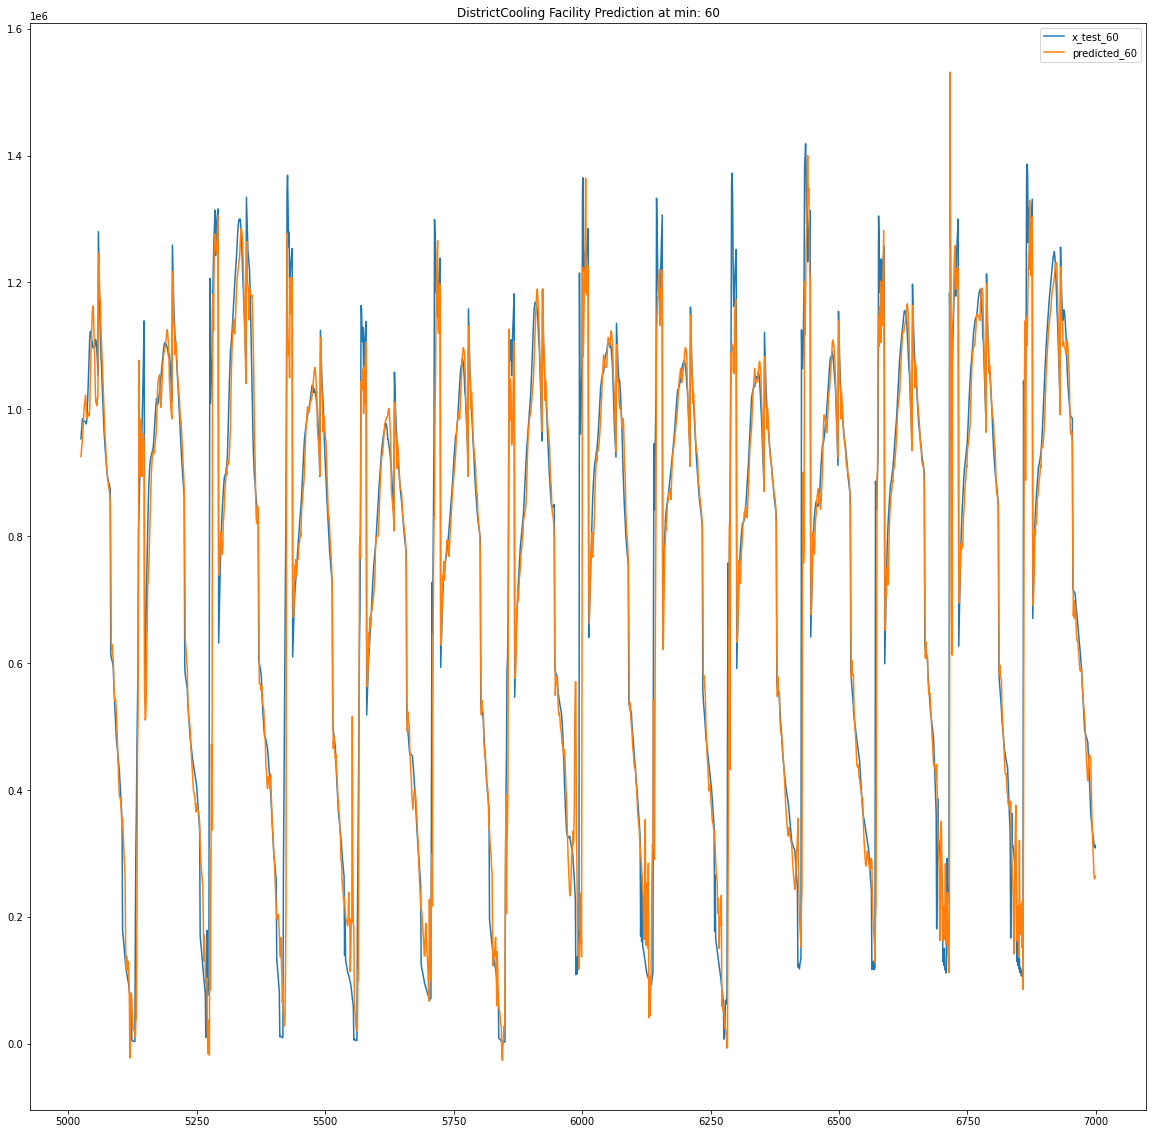

In [20]:
for i in range(n_out):
    
    plt.figure(figsize=(20,20))
#plot_test.reset_index(inplace=True,drop=True)
    plt.plot(test[i][5025:7000],label='x_test_'+str((i+1)*10))
    plt.plot(pred_df[i][5025:7000],label='predicted_'+str((i+1)*10))
    plt.legend()
    plt.title("DistrictCooling Facility Prediction at min: "+ str((i+1)*10))
    plt.savefig('min'+ str((i+1)*10)+'.png')
#print(plot_test[4:])
#print(pred_df[0:8])
#plot_test.reset_index(inplace=True,drop=True)
#print(plot_t.shape)
#print(pred_df.shape)

Text(0.5, 1.0, 'DistrictCooling Facility Prediction at min: ')

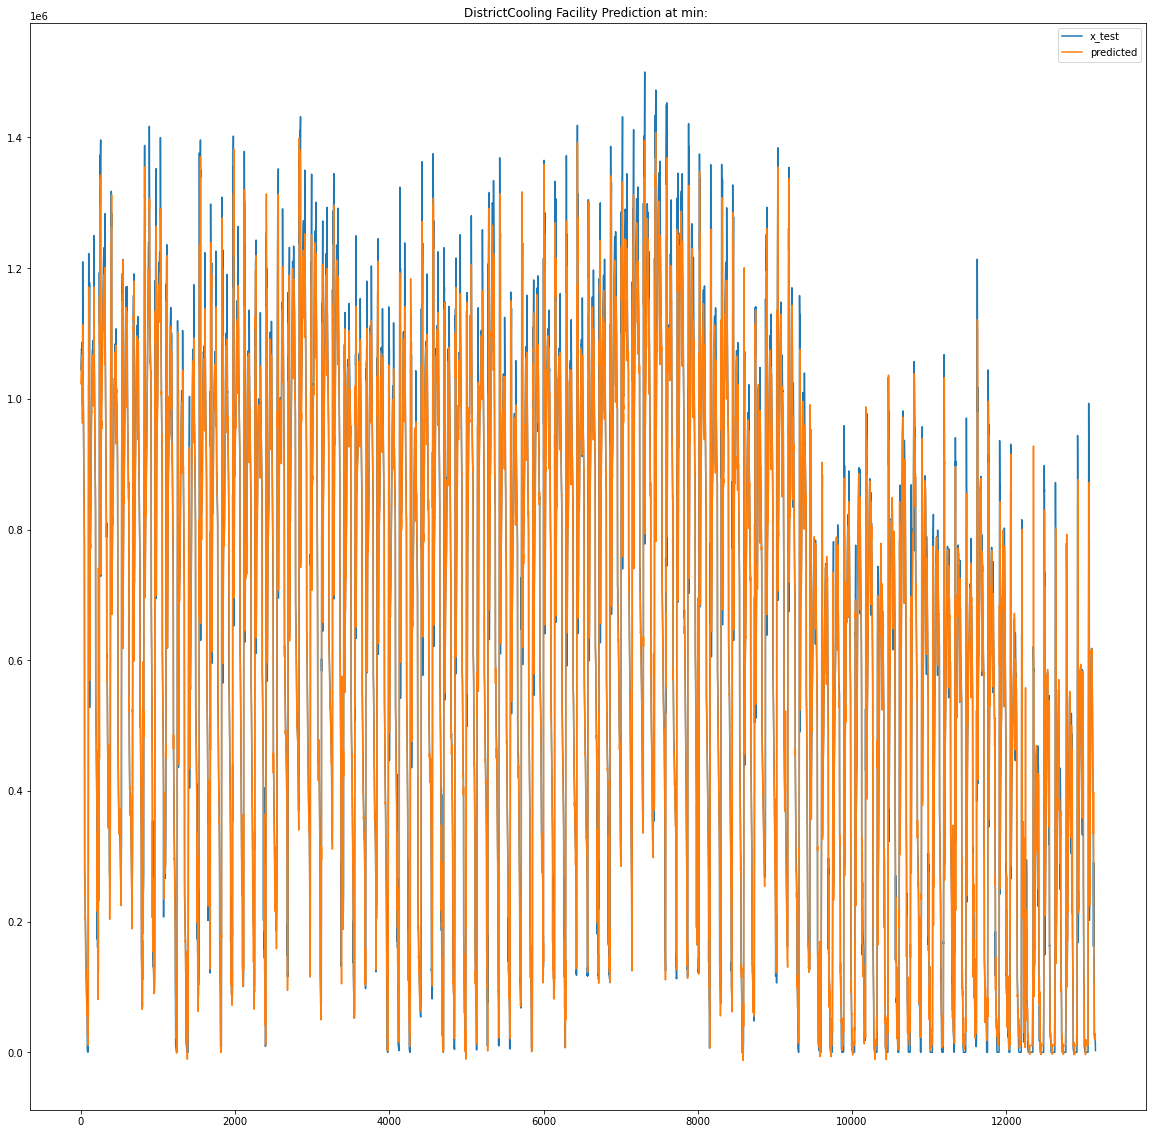

In [21]:
plt.figure(figsize=(20,20))
#plot_test.reset_index(inplace=True,drop=True)
plt.plot(test[1],label='x_test')
plt.plot(pred_df[1],label='predicted')
plt.legend()
plt.title("DistrictCooling Facility Prediction at min: ")


In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100

In [23]:
err_rmse={}
err_mae={}
err_mape={}
for i in range(n_out):
    err_rmse[i]=[]
    err_mae[i]=[]
    err_mape[i]=[]
for i in range(len(test)):
    for r in range(n_out):
        if test[r][i]!=0:
            err_rmse[r].append(np.sqrt(mean_squared_error(test[r], pred_df[r])))
            err_mae[r].append(mean_absolute_error(test[r], pred_df[r]))
            err_mape[r].append(np.abs(pred_df[r][i]-test[r][i])/(test[r][i]))

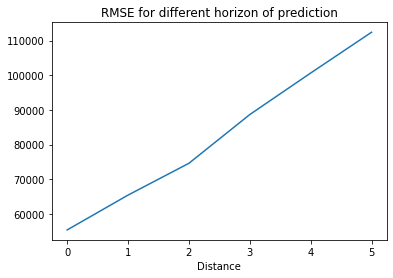

In [24]:
#Plot mean absolute percentage errore
mean=[]
for k in err_rmse.keys():
    mean.append(np.mean(err_rmse[k]))
plt.plot([v for v in mean])
plt.title("RMSE for different horizon of prediction")
plt.xlabel("Distance")
#plt.savefig('MAPEhorizon.png')
plt.show()

In [25]:
def calculate_metrics(inv_y,inv_yhat):
	# calculate metrics
	rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
	mse = mean_squared_error(inv_y, inv_yhat)
	mae = mean_absolute_error(inv_y, inv_yhat)
	mape = mean_absolute_percentage_error(inv_y, inv_yhat)
	return rmse, mse, mae, mape

In [26]:
rmse, mse, mae, mape = calculate_metrics(test, pred_df)

print("Test MSE: %.3f"%mse)
print('Test RMSE: %.3f' % rmse)
print("Test MAE: %.3f" % mae)
#print("Test MAPE: %.3f" % mape)

Test MSE: 7255506694.355
Test RMSE: 85179.262
Test MAE: 42476.819
